### Load Packages

In [0]:
# primary EDA code
import pandas as pd
import numpy as np
import os

# packages for plots
import matplotlib.pyplot as plt
import seaborn as sns

# warning ignore
import warnings
warnings.filterwarnings("ignore")

# packages for ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# packages for cross-validation
from sklearn.model_selection import KFold

### Load Data & Filter NA/ Duplicate Records

In [19]:
# Read files from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def data_import(folder_path, signal_type = "buy", number_of_days = 3):
    df_gp = pd.DataFrame()
    print()
    print("Loading", signal_type, "singal data:")
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
          
            # Stock ID is assume to be 4 digits
            stock = filename[0:4]
            
            print(stock, " ", end = '')
            try:
                temp_df = pd.read_csv(os.path.join(folder_path, filename), delimiter= '\s+', header = None)
                
                # Number of Days Adjustment
                if number_of_days == 9:
                  temp_df = pd.concat([temp_df.iloc[:, 0:41], temp_df.iloc[:, 118:159], temp_df.iloc[:, 236:277], temp_df.iloc[:, 354]],axis=1)
                  
                # Cut first 20 Records
                temp_df = temp_df.iloc[21:,:]
                temp_df = temp_df.reset_index(drop=True)
                
                # Buy/Sell Distinguished
                temp_df.rename(columns={123:'rtn'}, inplace=True)
                if signal_type == "buy":
                  temp_df = pd.concat([pd.Series([1] * temp_df.shape[0], name = 'signal_type'), temp_df], axis=1)
                else:
                  temp_df = pd.concat([pd.Series([0] * temp_df.shape[0], name = 'signal_type'), temp_df], axis=1)
                  temp_df['rtn'] = -temp_df['rtn']
                  
                # Merge into the Output Database
                df_gp = pd.concat([df_gp, temp_df])
                continue
                
            except:
                print('The following file cannot be read: ' + folder_path + filename)
        else:
            continue
    
    # Set all columns to numerics
    for col in df_gp.columns:
        df_gp[col] = pd.to_numeric(df_gp[col],errors='coerce')
            
    # Rename the columns 
    osc_headers = []
    stk_headers = []
    macd_headers = []
    for i in range(41):
        osc_headers.append('osc' + str(i))
        stk_headers.append('stk' + str(i))
        macd_headers.append('macd' + str(i))
    df_gp.columns = ['signal_type'] + osc_headers + stk_headers + macd_headers + ['rtn']
    
    # Reset index
    df_gp = df_gp.reset_index(drop=True)

    return df_gp

In [21]:
# Import Buy & Sell Data
df_buy9_gp = data_import('/content/gdrive/My Drive/capstone/data/9days/', signal_type = "buy", number_of_days = 9)
print()
df_buy_gp = data_import('/content/gdrive/My Drive/capstone/data/buy/', signal_type = "buy")
print()
df_sell_gp = data_import('/content/gdrive/My Drive/capstone/data/sell/', signal_type = "sell")

#df_combined = df_buy_gp
df_combined = pd.concat([df_buy9_gp, df_buy_gp, df_sell_gp])

# Drop Duplicated Records
len_before = df_combined.shape[0]
df_combined = df_combined.drop_duplicates(subset = df_combined.columns[1:])
print()
print()
print("Duplicates dropped:", len_before - df_combined.shape[0])

# Drop Records with NaN
len_before = df_combined.shape[0]
df_combined = df_combined.dropna()
print()
print("Record(s) w/ NaN dropped:", len_before - df_combined.shape[0])
print()

# Only model OSC > 1 or up 
#len_before = df_combined.shape[0]
#df_combined = df_combined[(df_combined.osc0 < -3) | (df_combined.osc0 > 3)]
#print("Small osc values dropped:", len_before - df_combined.shape[0])
#print()

# Reset Index
df_combined = df_combined.reset_index(drop=True)

print("Remained Records:", df_combined.shape[0])
print()

# Check the balance of df_gp
print('Positive returns:', round(np.sum(df_combined.rtn > 0)/len(df_combined.rtn) * 100, 2), '%')
print('Zero returns:', round(np.sum(df_combined.rtn == 0)/len(df_combined.rtn) * 100, 2), '%')
print('Negative returns:', round(np.sum(df_combined.rtn < 0)/len(df_combined.rtn) * 100, 2), '%')

# Check stock movement
print()
print('Avg Stock Movement %', np.mean(df_combined.rtn))
print('Max Stock Movement %', np.max(df_combined.rtn))
print('Min Stock Movement %', np.min(df_combined.rtn))


Loading buy singal data:
atiB  adbe  meli  pxdB  teck  cenx  aigB  acad  pruB  fslr  bidu  clfB  ufsB  bacB  uriB  crmB  crus  gsBu  csiq  masB  lvsB  jecB  jnpr  adsk  ssys  dbBu  ions  alny  itub  

Loading buy singal data:
adbe  ions  ssys  ati1  itub  alny  pxd1  ufs1  bac1  uri1  clf1  gs1B  jnpr  crm1  mas1  crus  pru1  bidu  fslr  csiq  jec1  db1B  acad  amd1  cenx  teck  meli  

Loading sell singal data:
csiq  fslr  bidu  lvsS  uriS  masS  pxdS  crmS  crus  pruS  meli  cenx  ufsS  acad  amdS  dbSe  teck  alny  itub  atiS  adsk  ssys  ions  adbe  gsSe  clfS  bacS  

Duplicates dropped: 68013

Record(s) w/ NaN dropped: 13

Remained Records: 215140

Positive returns: 48.53 %
Zero returns: 3.28 %
Negative returns: 48.19 %

Avg Stock Movement % 0.03653151436274062
Max Stock Movement % 338.81
Min Stock Movement % -440.0


### Split Data Into Parts

In [0]:
def data_organize(df_gp):
    try:
        signal_gp = df_gp.iloc[:, 0]
        osc_gp = df_gp.iloc[:, 1:42]
        stk_gp = df_gp.iloc[:, 42:83]
        macd_gp = df_gp.iloc[:, 83:124]
        rtn_gp = df_gp.iloc[:, 124]
        label_gp = rtn_gp
        label_gp = (rtn_gp > 0).map({False: -1, True: 1})
        for i in range(len(label_gp)):
          if rtn_gp[i] > 10:
            label_gp[i] = 10
          elif rtn_gp[i] < -5:
            label_gp[i] = -5
          elif rtn_gp[i] == 0:
            label_gp[i] = 0
        print('3+ :', round(np.sum(label_gp == 3)/len(label_gp) * 100, 2), '%')
        print('+ :', round(np.sum(label_gp > 0)/len(label_gp) * 100, 2), '%')
        print('0 :', round(np.sum(label_gp == 0)/len(label_gp) * 100, 2), '%')
        print('-:', round(np.sum(label_gp < 0)/len(label_gp) * 100, 2), '%')
        print('-3:', round(np.sum(label_gp == -3)/len(label_gp) * 100, 2), '%')
        
    except:
        print('Please check the dataframe index')

    return signal_gp, osc_gp, stk_gp, macd_gp, rtn_gp, label_gp

In [78]:
signal_gp, osc_gp, stk_gp, macd_gp, rtn_gp, label_gp = data_organize(df_combined)
#label_gp = (rtn_gp > 0).map({False: 0, True: 1})

3+ : 0.0 %
+ : 48.53 %
0 : 3.28 %
-: 48.19 %
-3: 0.0 %


### Feature Engineering - add Additional Features

In [0]:
def smooth_generator(data, name = "osc"):
    smooth_list = []
    for i in range(data.shape[0]):
        smooth_list.append(np.var(np.diff(np.diff(data.iloc[i,:])))/np.mean(data.iloc[i,:]))
    smooth = pd.DataFrame(smooth_list, columns=["smooth_" + name])
    return smooth

def derivative(data, space = 1, name = "d", relative = False):
    dy = []
    for i in range(data.shape[0]):
        y = pd.Series(data.iloc[i,:])
        # Relative change
        if relative == True:
            y = y/(np.mean(np.abs(y)))
        temp_dy = list(np.diff(y))
        #temp_dy = list(np.gradient(y, space))
        dy.append(temp_dy)

    col_name = []
    for i in range(len(temp_dy)):
        col_name.append(name + str(i))

    deriv_df = pd.DataFrame(dy, columns=col_name)

    return deriv_df

def psd_generator(data, NFFT = 100, name = "osc"):
    freq = []
    for i in range(data.shape[0]):
        data_osc = data.iloc[i,:]
        p = Periodogram(data_osc, NFFT=NFFT)
        temp_list = list(p.psd)
        freq.append(temp_list)
    col_name = []
    for i in range(int(NFFT/2)+1):
        col_name.append("psd"+str(i))

    psd_df = pd.DataFrame(freq, columns=col_name)
    return psd_df

def volatility(data):
    vol = []
    for i in range(data.shape[0]):
        vol.append(np.var(data.iloc[i,:]))
    vol = pd.DataFrame(vol, columns=["volatility"])
    return vol
  
def last_signal(data):
    last_signal_df = pd.DataFrame()
    last_signal_len = []
    last_signal_type = []
    
    for i in range(data.shape[0]):
        y = pd.Series(data.iloc[i,:])
        dy = list(np.diff(y))
        dy_sign = np.sign(dy)
        
        last_type = 0
        j = len(dy_sign) - 1
        
        for j in range(1, len(dy_sign) - 1):
          if dy_sign[j + 1] != dy_sign[j] and dy_sign[j + 1] != 0:
            last_time = j
            last_type = dy_sign[j + 1]
            break
        
        last_signal_len.append(last_time)
        last_signal_type.append(last_type)
            
    col_name = ['last_s_lennnnnnnnnn','last_s_type']
    
    last_signal_df = pd.DataFrame(pd.concat([pd.Series(last_signal_len),pd.Series(last_signal_type)], axis=1))
    last_signal_df.columns = col_name
    
    return last_signal_df
  
def ratio(osc, stk, macd):
    #ratio_osc_stk0 = osc.iloc[:, 0]/stk.iloc[:, 0]
    #ratio_osc_stk1 = osc.iloc[:, 1]/stk.iloc[:, 1]
    #ratio_osc_stk2 = osc.iloc[:, 2]/stk.iloc[:, 2]
    #ratio_osc_stk3 = osc.iloc[:, 3]/stk.iloc[:, 3]
    #ratio_osc_stk4 = osc.iloc[:, 4]/stk.iloc[:, 4]
    #ratio_osc_stk = pd.concat([ratio_osc_stk0, ratio_osc_stk1, ratio_osc_stk2, ratio_osc_stk3, ratio_osc_stk4],axis=1)
    #ratio_osc_stk.columns = ['ratio_os0','ratio_os1','ratio_os2','ratio_os3','ratio_os4']
    ratio_osc_macd0 = osc.iloc[:, 0]/macd.iloc[:, 0]
    ratio_osc_macd1 = osc.iloc[:, 1]/macd.iloc[:, 1]
    ratio_osc_macd2 = osc.iloc[:, 2]/macd.iloc[:, 2]
    ratio_osc_macd3 = osc.iloc[:, 3]/macd.iloc[:, 3]
    ratio_osc_macd4 = osc.iloc[:, 4]/macd.iloc[:, 4]
    ratio_osc_macd = pd.concat([ratio_osc_macd0, ratio_osc_macd1, ratio_osc_macd2, ratio_osc_macd3, ratio_osc_macd4],axis=1)
    
    ratio_osc_macd.columns = ['ratio_om0','ratio_om1','ratio_om2','ratio_om3','ratio_om4']
    
    return ratio_osc_macd

In [0]:
# calculate the dy for macd
first_deriv_macd = derivative(macd_gp, name="d_macd", relative = True)    

# calculate the ddy for macd
second_deriv_macd = derivative(first_deriv_macd, name="dd_macd", relative = False) 

# calculate the smooth for osc
#smooth_macd = smooth_generator(macd_gp,"macd")

In [0]:
# calculate the dy for osc
first_deriv_osc = derivative(osc_gp, name="d_osc", relative = True)

# calculate the ddy for osc
second_deriv_osc = derivative(first_deriv_osc, name="dd_osc", relative = False) 

# calculate the smooth for osc
smooth_osc = smooth_generator(osc_gp, "osc")

In [0]:
# calculate the dy for stock
first_deriv_stk = derivative(stk_gp, name="d_stk", relative = True)

# calculate the ddy for stock
second_deriv_stk = derivative(first_deriv_stk, name="dd_stk", relative = False)

# calculate the volatility for stock
vol_stk = volatility(stk_gp)

# calculate the smooth for osc
#smooth_stk = smooth_generator(stk_gp, "stk")

In [0]:
# Ratio
ratio_om = ratio(osc_gp, stk_gp, macd_gp)

### Combine Features

In [0]:
Feature_matrix_w_rtn = pd.concat([rtn_gp, signal_gp, ratio_om, smooth_osc, first_deriv_stk, second_deriv_stk, first_deriv_macd, second_deriv_macd, first_deriv_osc, second_deriv_osc, vol_stk, osc_gp.iloc[:,0], macd_gp.iloc[:,0]], axis=1)


### LGBM + 20 fold CV


In [84]:
results_summaries_collection = pd.DataFrame()
results_summaries_collection_tc = pd.DataFrame()

# n-fold Cross Validation
n = 20
p = 0
kf = KFold(n_splits = n, shuffle = True)
kf.get_n_splits(Feature_matrix_w_rtn)

# Within each fold
for train_index, test_index in kf.split(Feature_matrix_w_rtn):

    # Define train/ validation set (convert X_w_rtn and y to np.array for indexing on the next line)
    X_train_w_rtn, X_valid_w_rtn = Feature_matrix_w_rtn.values[train_index], Feature_matrix_w_rtn.values[test_index]
    y_train, y_valid = label_gp.values[train_index], label_gp.values[test_index]
    
    # Separate returns from Feature matrix (convert X_w_rtn and y back to pandas)
    X_train = pd.DataFrame(X_train_w_rtn).iloc[:, 2:]
    X_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 2:]

    rtn_train = pd.DataFrame(X_train_w_rtn).iloc[:, 0]
    rtn_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 0]
    sig_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 1]
    
    y_train = pd.Series(y_train)
    y_valid = pd.Series(y_valid)
    
    # Reset indices on all
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    rtn_train = rtn_train.reset_index(drop=True)
    
    X_valid = X_valid.reset_index(drop=True)
    y_valid = y_valid.reset_index(drop=True)
    rtn_valid = rtn_valid.reset_index(drop=True)
    
    # Train Model
    lg = lgb.LGBMRegressor(silent=False)
    data_train = lgb.Dataset(X_train, label=y_train)
    params = {"max_depth": 50, "learning_rate" : 0.01, "num_leaves": 300,  "n_estimators": 200}
    
    model2 = lgb.train(params, data_train)
    #model2 = lgb.train(data_train)
    
    # Extracts the probabilities of being a good trade
    proba_set_valid = model2.predict(X_valid)
    proba_valid = []
    for prob in range(len(proba_set_valid)):
        proba_valid.append(proba_set_valid[prob])
    
    scores = pd.DataFrame(proba_valid).rank(pct = True)
        
    # Put Results Together
    results = pd.concat([pd.DataFrame(proba_valid), pd.DataFrame(scores), y_valid, rtn_valid, sig_valid], axis =1)
    results.columns = ['prob', 'score', 'label', 'return', 'sig_ty']
    results['label'] = results['label'] > 0
    results['score'] = results['score']*100
    results['score_rd'] = np.round(results['score'],-1)
    
    # Make Results Summary
    results_summary = pd.concat([results.groupby(['score_rd']).mean()['label'], results.groupby(['score_rd']).count()['label'], results.groupby(['score_rd']).mean()['return'], results.groupby(['score_rd']).mean()['sig_ty']],axis=1)
    results_summary.columns = ['StkUpRate', 'Count', 'Stk Mvt%', 'BuySig%']
    results_summary['% of All Trades'] = np.round(results_summary['Count']/np.sum(results_summary['Count']),4)*100
    results_summary = results_summary.drop(['Count'], axis=1)
    
    # Store it in the Results Collection
    results_summaries_collection = pd.concat([results_summaries_collection, results_summary])
    
    # Print Progress
    p = p + 1
    print('Progress: ', round(p*100/n, 0), '%')

Progress:  5.0 %
Progress:  10.0 %
Progress:  15.0 %
Progress:  20.0 %
Progress:  25.0 %
Progress:  30.0 %
Progress:  35.0 %
Progress:  40.0 %
Progress:  45.0 %
Progress:  50.0 %
Progress:  55.0 %
Progress:  60.0 %
Progress:  65.0 %
Progress:  70.0 %
Progress:  75.0 %
Progress:  80.0 %
Progress:  85.0 %
Progress:  90.0 %
Progress:  95.0 %
Progress:  100.0 %


In [85]:
results_summaries_collection.groupby(['score_rd']).mean()

,StkUpRate,Stk Mvt%,BuySig%,% of All Trades
score_rd,,,,
0.0,0.443762,-0.041894,0.658101,4.99
10.0,0.402556,0.020035,0.956645,10.00
20.0,0.411245,0.035393,0.985316,10.00
30.0,0.409349,0.020978,0.981535,9.99
40.0,0.427556,0.065177,0.964405,10.00
50.0,0.457063,0.084723,0.769424,10.00
60.0,0.535270,0.022933,0.164591,10.00
70.0,0.559163,0.023853,0.023488,9.99
80.0,0.568541,0.026230,0.010595,10.00


[Text(0.5, 0, 'Score')]

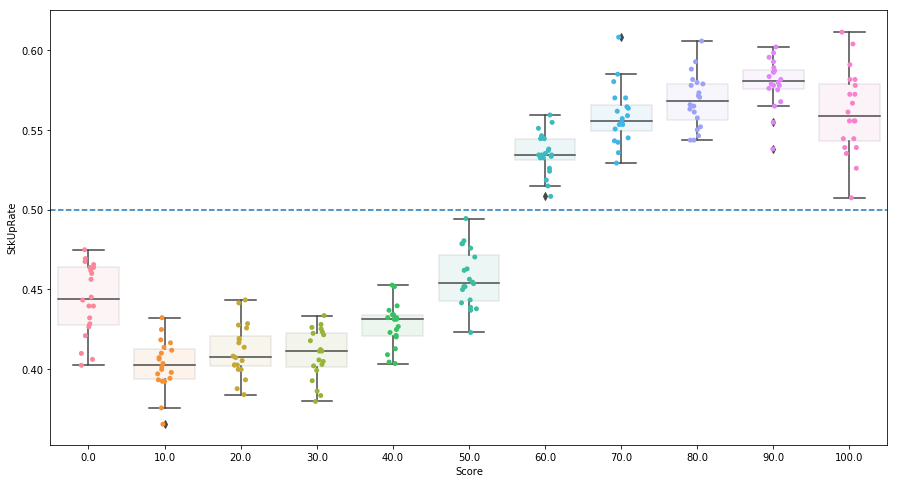

In [86]:
plt.figure(figsize=(15,8))
df_plot = results_summaries_collection.reset_index()
ax = sns.stripplot(y=df_plot["StkUpRate"], x=df_plot["score_rd"])
ax = sns.boxplot(y=df_plot["StkUpRate"], x=df_plot["score_rd"], boxprops=dict(alpha=.1))
ax.axhline(0.5, ls='--')
ax.set(xlabel='Score')

[Text(0.5, 0, 'Score')]

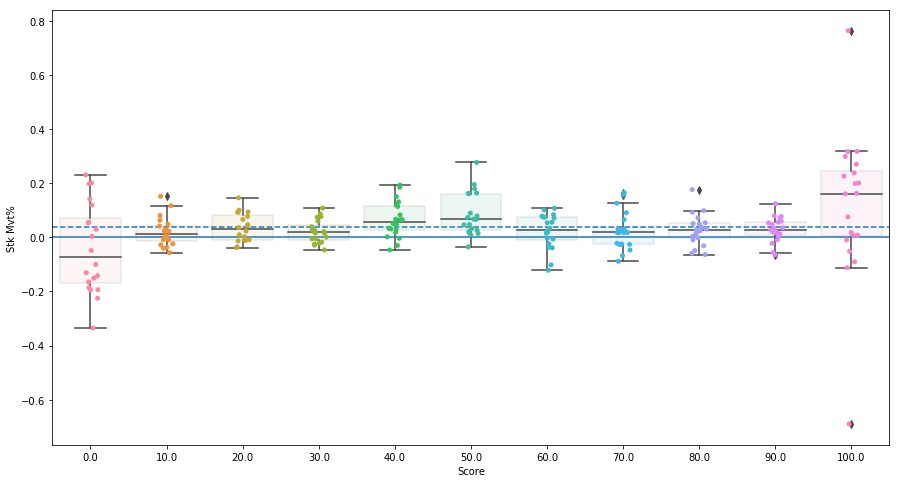

In [87]:
plt.figure(figsize=(15,8))
df_plot = results_summaries_collection.reset_index()
ax = sns.stripplot(y=df_plot["Stk Mvt%"], x=df_plot["score_rd"])
ax = sns.boxplot(y=df_plot["Stk Mvt%"], x=df_plot["score_rd"], boxprops=dict(alpha=.1))
ax.axhline(np.mean(df_combined.rtn), ls='--')
ax.axhline(0, ls='-')
ax.set(xlabel='Score')
#ax.set_ylim(-2,3)

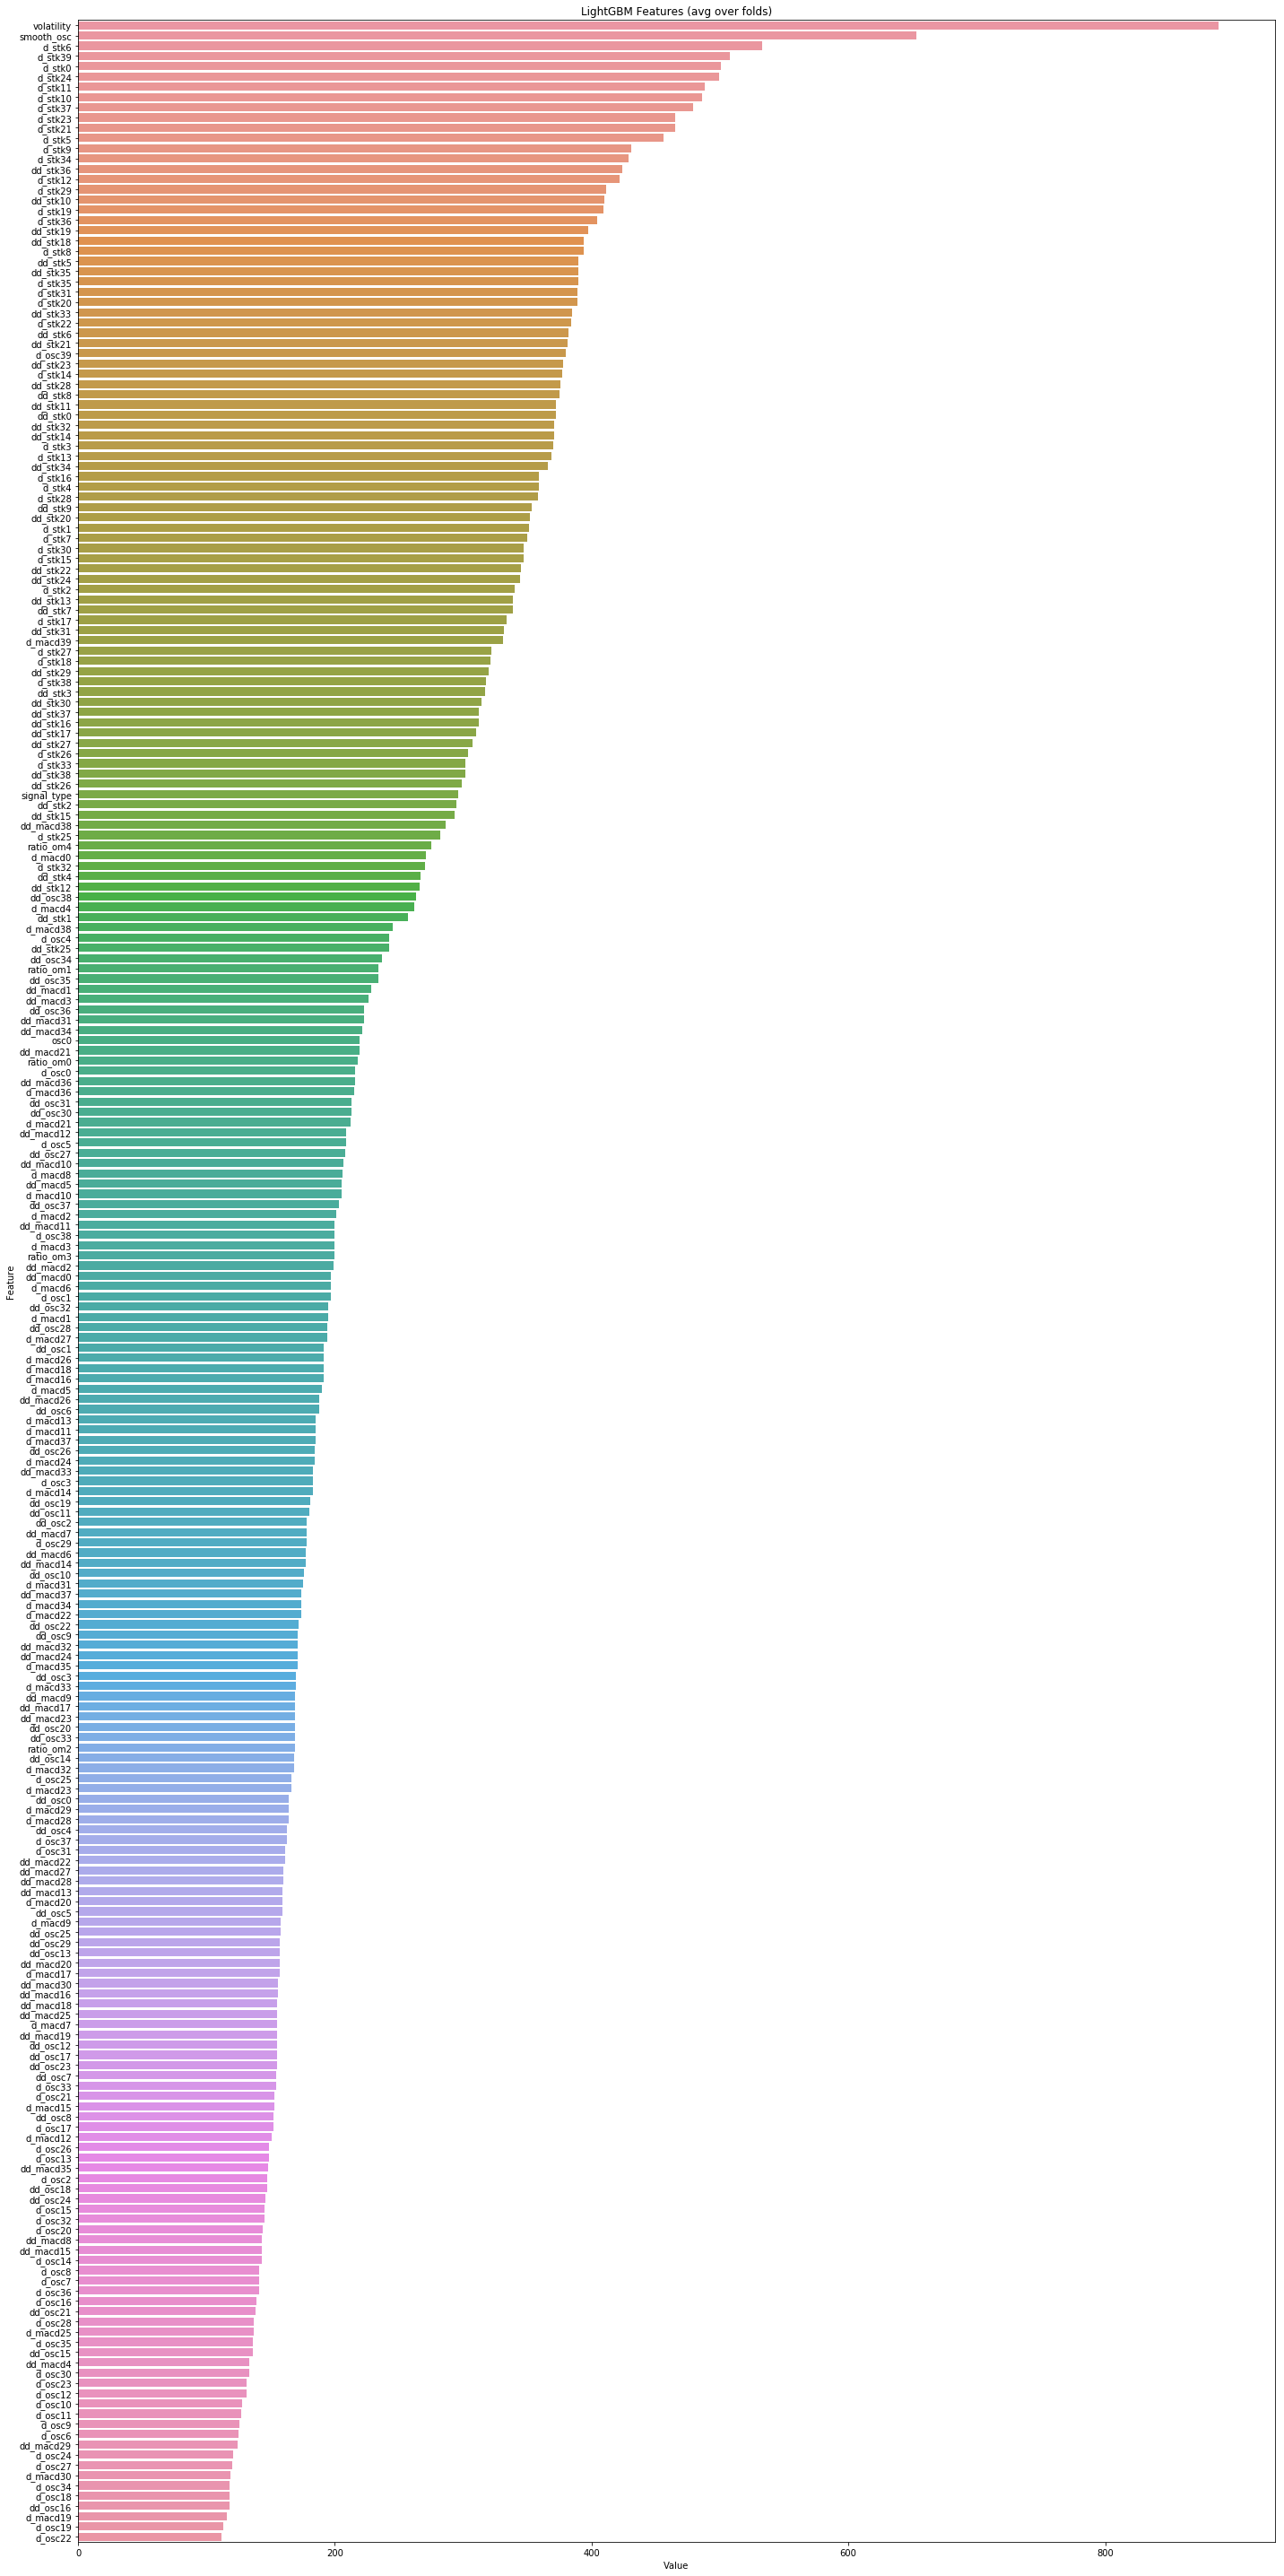

In [88]:
feature_imp = pd.DataFrame(sorted(zip(model2.feature_importance(),Feature_matrix_w_rtn.columns[1:])), columns=['Value','Feature'])

plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()